In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable warning for chained assignments
import numpy as np
import scipy
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='white', font_scale=1.5)  # Set seaborn style and font scale
import matplotlib.gridspec as gridspec
import auxiliary  # Import auxiliary module
aux = auxiliary.Auxiliary()  # Create an instance of the Auxiliary class
import emotioncon_stats  # Import emotioncon_stats module
emostats = emotioncon_stats.Statistics()  # Create an instance of the Statistics class

In [2]:
# Load the experiment data
data = np.load('../results/data_experiment.npy', allow_pickle=True)
Nsj = len(data) # number of subjects
print('number of subjects: ' + str(Nsj))

# Initialize lists and a DataFrame
mood_rating_list, symptoms_list = [], []
df = pd.DataFrame()

# Iterate over the data to extract mood ratings and intervention conditions
for j, i in enumerate(data):
    mood_rating_list.append(i['ratings'])
    df.loc[j, 'randomized_condition'] = i['iddoc']['intervention_condition']
    df.loc[j, 'randomized_videoset'] = i['iddoc']['videoset_condition']

# Convert the mood ratings list to an array and transpose it
mood_ratings = np.array(mood_rating_list).T

# Rearrange mood_ratings to match the ratings format (see below)
mood_ratings = mood_ratings[:55, [2, 1, 4, 3, 0], :]

# Define the mood categories
mood_categories = ['calm', 'amused', 'sad', 'anxious', 'disgusted']

number of subjects: 108


In [3]:
# Load the experiment video list and original ratings from Cowen & Keltner paper (PNAS, 2017)
df_experimentVideoList = pd.read_csv('../experiment/public/prep/videosForExperiment.csv')
original_ratings = pd.read_csv('../experiment/public/videos/videosRatingsCowenKeltner.csv')

# Define categories of interest and their backup categories
categories_of_interest = ['Calmness', 'Amusement', 'Sadness', 'Anxiety', 'Disgust']
backup_category = ['Aesthetic', 'Joy', 'Sympathy', 'Fear', 'Horror']

# Initialize arrays to store ratings
paper_ratings, study_ratings = [np.full((54, 5, 2), np.nan) for _ in range(2)]

# Iterate over the video sets
for i in range(1, 3):
    dd = mood_ratings[:, :, (df['randomized_videoset'] == i-1)]
    study_ratings[:, :, i-1] = np.nanmean(dd[1:55, :, :], axis=2)
    
    # Iterate over the videos in each video set
    for j in range(len(df_experimentVideoList['videoset' + str(i)])):
        # Extract ratings from the Cowen & Keltner paper and add them to paper_ratings
        paper_ratings[j, :, i-1] = original_ratings[categories_of_interest] \
            [original_ratings['videoID'] == df_experimentVideoList['videoset' + str(i)][j]].values \
            + original_ratings[backup_category] \
            [original_ratings['videoID'] == df_experimentVideoList['videoset' + str(i)][j]].values / 2

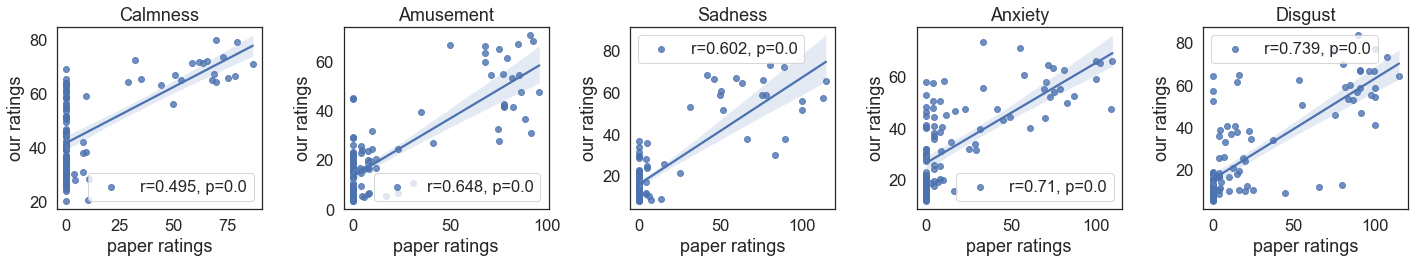

In [4]:
# Plot & calculate correlation between ratings of our study and the Cowen&Keltner ratings
fig,axs = plt.subplots(1,5,figsize=(20,4))    
for m in range(5):
    sns.regplot(x=paper_ratings[:,m,:].flatten(), y=study_ratings[:,m,:].flatten(), ax=axs[m])
    axs[m].set(xlabel='paper ratings', ylabel='our ratings', title=categories_of_interest[m])
    [r,p] = np.round(scipy.stats.spearmanr(paper_ratings[:,m,:].flatten(), study_ratings[:,m,:].flatten()),3)
    axs[m].legend(['r='+str(r)+', p='+str(p)])
plt.tight_layout()

In [5]:
# Create a DataFrame to store the ordered categories of our experiment
df_ordered_category = pd.DataFrame(index=range(len(df_experimentVideoList['category'])))

# Iterate over the mood categories
for m in mood_categories:
    # Find the indices of videos in the experiment that match the mood category
    idx = [j for j, i in enumerate(df_experimentVideoList['category'].str.lower()) if m[:3] in i]
    
    # Assign the mood category to the corresponding rows in the DataFrame
    df_ordered_category.loc[idx, 'mood'] = m

In [6]:
# Initialize lists and arrays to store autocorrelation and cross-correlation results
ar, cr, pp = [], [], []
crosscorr = np.empty((5, 5, Nsj))
lags = 6 # Specify maximal lags of autocorrelation

# Iterate over the subjects
for n in range(Nsj):
    # Extract mood ratings for the current subject from the first video block only
    tmp = mood_ratings[:55, :, n]
    
    # Initialize lists to store autocorrelation and p-values
    autocorr_coeff, pval = [], []
    
    # Iterate over the mood categories
    for i in range(5):
        # Calculate autocorrelation and p-values using the acf function from stattools
        autocorr = stattools.acf(tmp[:, i], nlags=lags, qstat=True)
        autocorr_coeff.append(autocorr[0][:lags])
        
        # Calculate cross-correlation between mood categories using Spearman's correlation coefficient
        for j in range(5):
            crosscorr[i, j, n] = scipy.stats.spearmanr(tmp[:, i], tmp[:, j])[0]
            
    # Store the results in the corresponding lists and arrays
    cr.append(np.corrcoef(tmp.T))
    ar.append(np.array(autocorr_coeff))
    pp.append(np.array(pval))

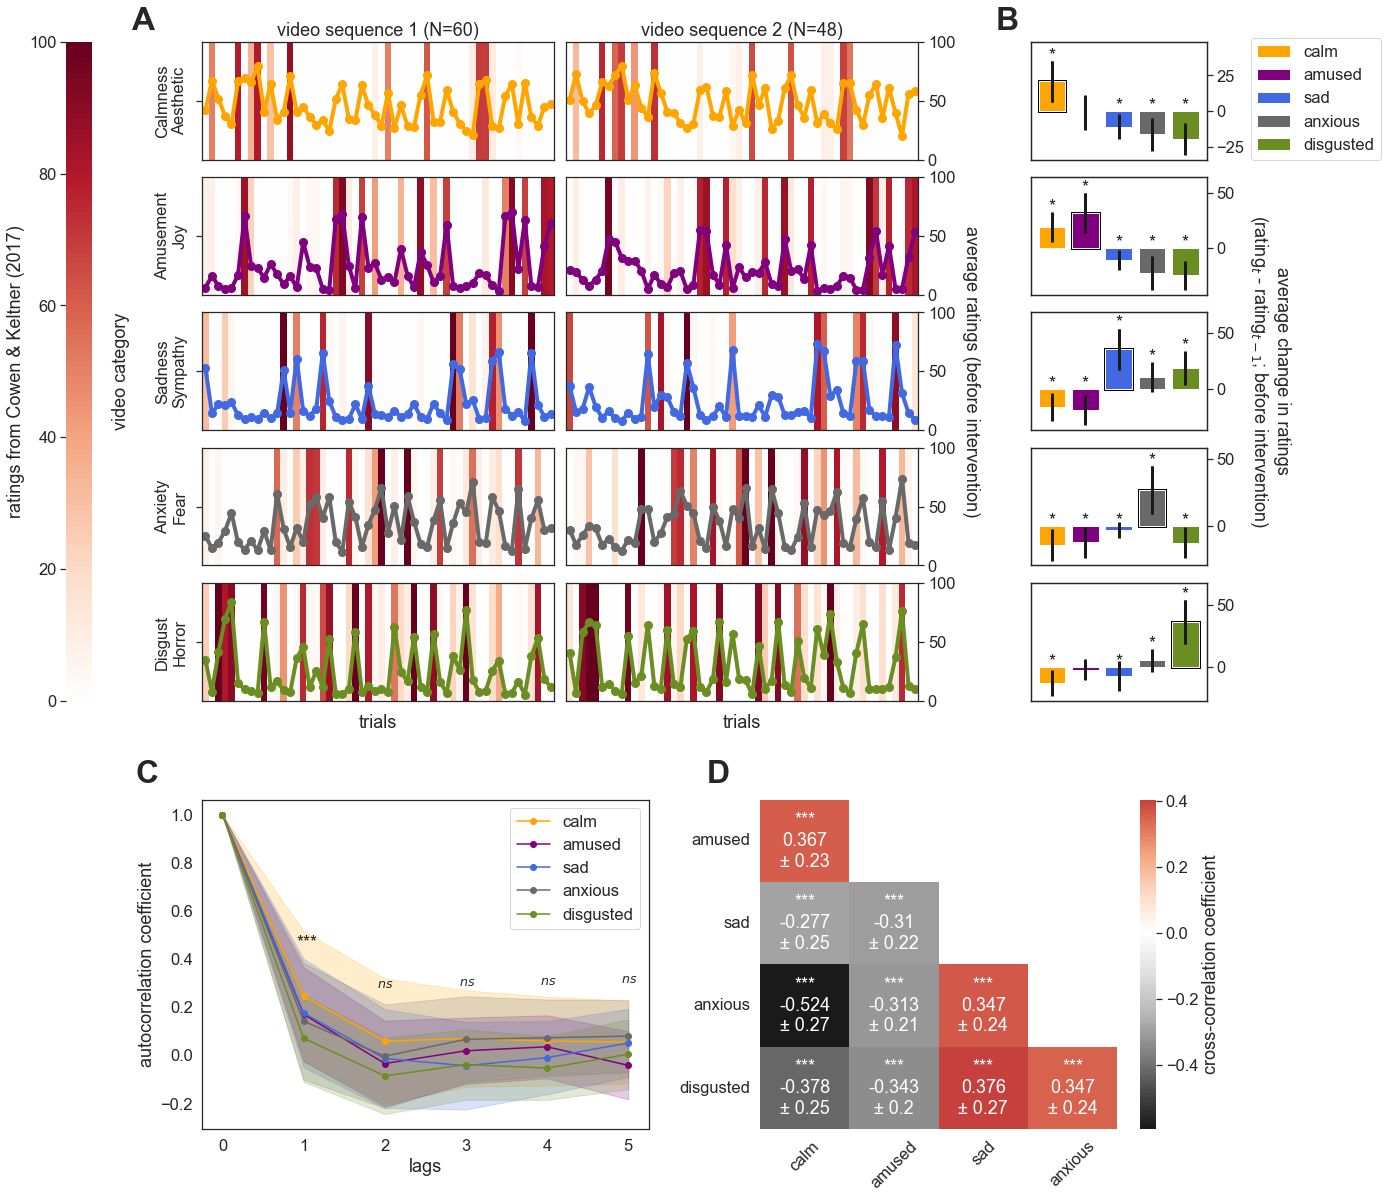

In [8]:
# A) plot overlap of our ratings and Cowen&Keltner ratings
# B) plot average change in ratings after videos from a specific video category shown
# C) plot autocorrelation of emotion ratings for different lags
# D) plot cross-correlation of emotion ratings

color = ['orange', 'purple', 'royalblue', 'dimgray', 'olivedrab']

fig = plt.figure(figsize=(18, 20))
outer = gridspec.GridSpec(2, 1, height_ratios=(6,3), hspace=0.2, wspace=0.2)

# Top panel
inner = gridspec.GridSpecFromSubplotSpec(5, 4, width_ratios=(4,4,1,2), \
                                         subplot_spec=outer[0], wspace = 0.05, hspace=0.15)
axs=np.empty((5,4), dtype=object)
pos = np.empty((2))
for i in range(4):
    for j in range(5):
        ax = plt.Subplot(fig, inner[j,i])
        axs[j,i] = fig.add_subplot(ax, sharey=ax, sharex=ax)
        if (i==0) & (j==4): pos[0] = axs[j,i].get_position().y0
        if (i==1) & (j==0): pos[1] = axs[j,i].get_position().y1
cbar_ax = fig.add_axes([0.02, pos[0], .02, pos[1]-pos[0]])

# Ratings
for i in range(1,3):
    rating_list = []
    for j in range(len(df_experimentVideoList['videoset' + str(i)])):
        rating_list.append(original_ratings[categories_of_interest]\
                           [original_ratings['videoID'] \
                            == df_experimentVideoList['videoset' + str(i)][j]].values\
                            +\
                            original_ratings[backup_category]\
                                                       [original_ratings['videoID'] \
                                                        == df_experimentVideoList['videoset' + str(i)][j]].values\
                            /2)

    for m in range(5):
        b = sns.heatmap(np.array(rating_list).squeeze()[:,m].reshape(-1,1).T,\
                        ax=axs[m,i-1], cmap="RdGy_r", center=0, cbar=True, cbar_ax=cbar_ax, \
                        cbar_kws={'label': 'ratings from Cowen & Keltner (2017)'}, vmin=0, vmax=100)
        if i == 1: b.set_yticklabels([categories_of_interest[m] + '\n' + backup_category[m]], \
                                     va='center', ha="center")
        else: b.set(yticks=[], yticklabels=[])
        b.tick_params(axis='y', which='major', pad=25)
        if m == 2 and i == 1: b.set_ylabel('video category', labelpad=25)
        if m == 0: b.set_title('video sequence ' + str(i) + \
                               ' (N=' + str(sum(df['randomized_videoset']==i-1)) + ')')
        b.set_xticklabels([])
        if m == 4: b.set_xlabel('trials')
        ax2 = axs[m,i-1].twinx()
        study_rating_list = mood_ratings[:,:,(df['randomized_videoset']==i-1)]
        ax2.plot(np.arange(54)+0.5, np.nanmean(study_rating_list[1:55,m,:],axis=1), \
                 marker='o', markersize=8, linewidth=4, color=color[m], label=mood_categories[m])
        if i == 1: ax2.set(yticks=[], yticklabels=[])
        ax2.set_ylim([0,100])
#         if i == 2 and m == 0: ax2.legend(loc=(0.005,0.02))
#         elif i == 2: ax2.legend(loc=(0.005,0.73))
        if m == 2 and i == 2: ax2.set_ylabel('average ratings (before intervention)', rotation=270, labelpad=25)
b.collections[0].colorbar.ax.yaxis.set_label_position('left')
b.collections[0].colorbar.ax.yaxis.set_ticks_position('left')
axs[0,0].text(-0.04*5, 1.1, 'A', transform=axs[0,0].transAxes, weight='bold', size=32)

# Change in ratings
tmp = mood_ratings[1:55,:,:] - mood_ratings[:54,:,:]
mm, annot = [], []
for i in range(5):
    axs[i,2].set_axis_off()
    ax2 = axs[i,3].twinx()
    mm = np.nanmean(tmp[(df_ordered_category==mood_categories[i]).values.squeeze(),:,:],(0,2))
    ss = np.std(np.nanmean(tmp[(df_ordered_category==mood_categories[i]).values.squeeze(),:,:],0),1)
    for s in range(5):
        if s == i:
            ax2.bar(x=s, height=mm[s], yerr=ss[s], \
                    color=color[s], error_kw={'linewidth':3}, edgecolor='black', \
                    linewidth=3)
        ax2.bar(x=s, height=mm[s], yerr=ss[s], \
                color=color[s], label=mood_categories[s], error_kw={'linewidth':3})
        if (s==1) and (i==0 or i==4): 
            continue
        if mm[s] < 0: y = 0
        else: y = mm[s] + ss[s]
        ax2.text(s, y, '*', ha='center')

    axs[i,3].set(xticks=[], xticklabels=[], yticks=[], yticklabels=[])
    if i == 2: ax2.set_ylabel('average change in ratings\n(rating$_t$ - rating$_{t-1}$; before intervention)', \
                                   va='center', rotation=270, labelpad=35)
    if i ==0: ax2.legend(loc=(ax2.get_position().x1+0.35,0))
    ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1]+10)
axs[0,3].text(-0.04*5, 1.1, 'B', transform=axs[0,3].transAxes, weight='bold', size=32)

# Buttom panel
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1,:], wspace = 0.25)
axs=np.empty((2), dtype=object)
for i in range(2):
    ax = plt.Subplot(fig, inner[i])
    axs[i] = fig.add_subplot(ax, sharey=ax, sharex=ax)
    
# Autocorrelation
sig = ['*'] +  9*['$^{ns}$']
for i in range(5):
    y = np.nanmean((np.array(ar)[:,i,:]),axis=0)
    x = range(len(y))
    error = np.nanstd((np.array(ar)[:,i,:]),axis=0)
    axs[0].plot(x, y, '-o', label=mood_categories[i], color=color[i])
    axs[0].fill_between(x, y-error, y+error, alpha=0.2, color=color[i])
for t in range(1,np.array(ar).shape[-1]):
    p = np.median(scipy.stats.ttest_1samp(np.array(ar)[:,:,t], popmean=0)[1])
    sig = aux.pval_to_asterix(p*50)
    axs[0].text(x[t]-0.05-((len(sig))>1)*0.04, np.max(np.nanmean((np.array(ar)[:,:,t]),axis=0))+0.2, \
               sig, fontsize=18+((len(sig))==1)*2)
axs[0].set(xlabel='lags', ylabel='autocorrelation coefficient')
axs[0].legend();
axs[0].text(-0.15, 1.05, 'C', transform=axs[0].transAxes, weight='bold', size=32)

# Cross-correlation
annot = np.empty((5,5), dtype=object)
for i in range(5):
    for j in range(5):
        p = scipy.stats.ttest_1samp(np.array(cr)[:,i,j], popmean=0)[1]
        annot[i,j] = aux.pval_to_asterix(p*10) + '\n' + str(np.round(np.nanmean(np.array(cr)[:,i,j]),3)) + '\n± ' \
        + str(np.round(np.nanstd(np.array(cr)[:,i,j]),2))
m = np.nanmedian(np.array(cr),axis=0)[1:,:-1]
matrix = np.triu(m,k=1)
g = sns.heatmap(m, annot=annot[1:,:-1], fmt='', cmap='RdGy_r', ax = axs[1], \
                mask=matrix, center=0, cbar_kws={'label': 'cross-correlation coefficient'})
g.set_yticklabels(mood_categories[1:],rotation=0);
g.set_xticklabels(mood_categories[:-1],rotation=45);
axs[1].text(-0.15, 1.05, 'D', transform=axs[1].transAxes, weight='bold', size=32);

plt.savefig('../results/figures/emotion_dynamics.svg', bbox_inches='tight')

In [9]:
# Table showing mean change rating over videos of specific category in first block (before intervention)
# 1) different to 0
# 2) dominant emotion greater than non-dominant emotions

T1,p1,T2,p2,mm1,mm2 = [[] for i in range(6)]
for m in range(5):
    tmp = mood_ratings[1:,:,:] - mood_ratings[:-1,:,:]
    for i in range(5):
        idx = (df_ordered_category==mood_categories[m]).values.squeeze()
        mm1.append(str(np.round(np.nanmean(tmp[idx,m,:]),2)) + ' $\pm$ ' + \
                str(np.round(np.nanstd(tmp[idx,m,:]),2)))
        if i != m:
            mm2.append(str(np.round(np.nanmean(tmp[idx,i,:]),2)) + ' $\pm$ ' + \
                str(np.round(np.nanstd(tmp[idx,i,:]),2)))
            res1 = scipy.stats.ttest_ind(np.nanmean(tmp[idx,m,:],axis=0),\
                                        np.nanmean(tmp[idx,i,:],axis=0),\
                                       alternative='greater')
            T1.append(np.round(res1.statistic,2))
            if res1.pvalue < 0.001: p1.append('$<$0.001')
            else: p1.append(np.round(res1.pvalue,3))
        else:
            mm2.append(np.nan)
            T1.append(np.nan)
            p1.append(np.nan)
            
        res2 = scipy.stats.ttest_1samp(np.nanmean(tmp[idx,i,:],axis=0),popmean=0)
        T2.append(np.round(res2.statistic,2))
        if res2.pvalue < 0.001: p2.append('$<$0.001')
        else: p2.append(np.round(res2.pvalue,3))
        # permutation test
#         res = scipy.stats.permutation_test((np.nanmean(tmp[(df_category==mood_categories[m]).values.squeeze(),m,:],axis=0),\
#                                     np.nanmean(tmp[(df_category==mood_categories[m]).values.squeeze(),i,:],axis=0)),\
#                             t_statistic, alternative='greater', random_state=42)
#         print(np.round(res.pvalue,3), np.round(res.statistic,2))
df_stats_mean = pd.DataFrame([mm1, mm2, [m + '$>$' + j for m in mood_categories for j in mood_categories], \
                              T1, p1, [j + '$\neq$0' for m in mood_categories for j in mood_categories], T2, p2], \
             index=['main emotion (M$\pm$SD)', 'non-dominant emotion (M$\pm$SD)','test', 'statistics', 'pvalue', \
                    'test', 'statistics', 'pvalue'], \
                     columns=[categories_of_interest[m] + '/' + backup_category[m] + ':' \
                              for m in range(5) for j in range(5)]).T
df_stats_mean
# print(df_stats_mean.to_latex(escape=False))

,main emotion (M$\pm$SD),non-dominant emotion (M$\pm$SD),test,statistics,pvalue,test,statistics,pvalue
Calmness/Aesthetic:,20.93 $\pm$ 31.33,NaN,calm$>$calm,NaN,NaN,calm$\neq$0,15.03,$<$0.001
Calmness/Aesthetic:,20.93 $\pm$ 31.33,-1.04 $\pm$ 27.45,calm$>$amused,11.88,$<$0.001,amused$\neq$0,-0.86,0.393
Calmness/Aesthetic:,20.93 $\pm$ 31.33,-11.09 $\pm$ 25.53,calm$>$sad,19.64,$<$0.001,sad$\neq$0,-13.07,$<$0.001
Calmness/Aesthetic:,20.93 $\pm$ 31.33,-16.48 $\pm$ 28.9,calm$>$anxious,21.11,$<$0.001,anxious$\neq$0,-15.03,$<$0.001
Calmness/Aesthetic:,20.93 $\pm$ 31.33,-19.68 $\pm$ 32.69,calm$>$disgusted,23.06,$<$0.001,disgusted$\neq$0,-18.25,$<$0.001
Amusement/Joy:,31.84 $\pm$ 36.0,18.92 $\pm$ 27.77,amused$>$calm,5.93,$<$0.001,calm$\neq$0,14.38,$<$0.001
Amusement/Joy:,31.84 $\pm$ 36.0,NaN,amused$>$amused,NaN,NaN,amused$\neq$0,18.32,$<$0.001
Amusement/Joy:,31.84 $\pm$ 36.0,-10.56 $\pm$ 24.1,amused$>$sad,21.73,$<$0.001,sad$\neq$0,-11.89,$<$0.001
Amusement/Joy:,31.84 $\pm$ 36.0,-22.69 $\pm$ 31.7,amused$>$anxious,23.86,$<$0.001,anxious$\neq$0,-15.28,$<$0.001
Amusement/Joy:,31.84 $\pm$ 36.0,-24.58 $\pm$ 35.07,amused$>$disgusted,26.18,$<$0.001,disgusted$\neq$0,-19.28,$<$0.001


In [10]:
# Table showing ar and cr different from 0
stats_ar = np.empty((5,20))
for i in range(5):
    for t in range(lags-1):
        T,p = scipy.stats.ttest_1samp(np.array(ar)[:,i,t+1], popmean=0)
        stats_ar[t,i*4] = np.round(np.nanmean(np.array(ar)[:,i,t+1]),2) 
        stats_ar[t,i*4+1] = np.round(np.nanstd(np.array(ar)[:,i,t+1]),2) 
        stats_ar[t,i*4+2] = np.round(T,2)
        stats_ar[t,i*4+3] = np.round(p,3)
df_stats_ar = pd.DataFrame(stats_ar, columns=[np.repeat(mood_categories, 4), 5*['M', 'SD', 'statistic', 'pvalue']], \
             index=[5*['lags'], np.arange(1,6)])
for m in mood_categories:
    df_stats_ar[m, 'pvalue'][df_stats_ar[m, 'pvalue']<0.001] = '$<$0.001'
display(df_stats_ar)
# print(df_stats_ar.to_latex(escape=False))

stats_cr = np.empty((10,4))
k=0
for i in range(5):
    for t in range(5):
        if t < i:
            T,p = scipy.stats.ttest_1samp(np.array(cr)[:,i,t], popmean=0)
            stats_cr[k,0] = np.round(np.nanmean(np.array(cr)[:,i,t]),2) 
            stats_cr[k,1] = np.round(np.nanstd(np.array(cr)[:,i,t]),2) 
            stats_cr[k,2] = np.round(T,2)
            stats_cr[k,3] = np.round(p,3)
            k +=1
df_stats_cr = pd.DataFrame(stats_cr, columns=['M', 'SD', 'statistic', 'pvalue'], \
             index=['corr(' + mood_categories[i] + ', ' + mood_categories[t] + ')' for i in range(5) for t in range(5) if t < i])
df_stats_cr['pvalue'][df_stats_cr['pvalue']<0.001] = '$<$0.001'
display(df_stats_cr)
# print(df_stats_cr.to_latex(escape=False))

calm                           amused                             sad  \
           M    SD statistic    pvalue      M    SD statistic    pvalue     M   
lags 1  0.25  0.27      9.39  $<$0.001   0.17  0.19      9.05  $<$0.001  0.18   
     2  0.06  0.26      2.34     0.021  -0.03  0.18     -1.96     0.052 -0.01   
     3  0.07  0.20      3.60  $<$0.001   0.02  0.14      1.43     0.154 -0.04   
     4  0.06  0.18      3.33     0.001   0.04  0.13      2.82     0.006 -0.01   
     5  0.06  0.17      3.34     0.001  -0.04  0.14     -3.02     0.003  0.05   

                                 anxious                           disgusted  \
          SD statistic    pvalue       M    SD statistic    pvalue         M   
lags 1  0.23      8.05  $<$0.001    0.14  0.24      6.04  $<$0.001      0.07   
     2  0.21     -0.66     0.514   -0.00  0.21     -0.17     0.865     -0.09   
     3  0.18     -2.46     0.015    0.07  0.18      3.87  $<$0.001     -0.04   
     4  0.15     -0.62     0.534    0.07  0.16      4.78  $<$0.001     -0.05   
     5  0.14      3.76  $<$0.001    0.08  0.15      5.52  $<$0.001      0.00   

                                  
          SD statistic    pvalue  
lags 1  0.18      4.05  $<$0.001  
     2  0.16     -5.58  $<$0.001  
     3  0.15     -2.69     0.008  
     4  0.13     -4.12  $<$0.001  
     5  0.15      0.33      0.74

,M,SD,statistic,pvalue
"corr(amused, calm)",0.37,0.23,16.20,$<$0.001
"corr(sad, calm)",-0.28,0.25,-11.46,$<$0.001
"corr(sad, amused)",-0.31,0.22,-14.45,$<$0.001
"corr(anxious, calm)",-0.52,0.27,-19.81,$<$0.001
"corr(anxious, amused)",-0.31,0.21,-15.50,$<$0.001
"corr(anxious, sad)",0.35,0.24,14.97,$<$0.001
"corr(disgusted, calm)",-0.38,0.25,-15.76,$<$0.001
"corr(disgusted, amused)",-0.34,0.20,-17.94,$<$0.001
"corr(disgusted, sad)",0.38,0.27,14.55,$<$0.001
"corr(disgusted, anxious)",0.35,0.24,15.23,$<$0.001
